# Winning in the Big Leagues

In [1]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline 
import seaborn as sns
sns.set_style('ticks')
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import confusion_matrix
import itertools
import xgboost as xgb
from xgboost import plot_importance
import warnings
from datetime import datetime, timedelta
from fbprophet import Prophet
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Importing plotly failed. Interactive plots will not work.


In [2]:
# Read in CSV File
df = pd.read_csv('file:///Users/chrisfiorentine/Downloads/game_logs.csv')

In [3]:
# Use only years after 2015 
df = df[df['date'] > 20150000]

In [4]:
# Creating Run Diferential
df['Run_dif'] = df.h_score - df.v_score

In [5]:
# Creating Wins
def wins(rd):
    if rd > 0:
        return 1
    if rd < 0:
        return 0

In [6]:
df['Win'] = df['Run_dif'].apply(wins)

In [7]:
# Drop not needed columns
drop_columns = ['v_line_score','h_line_score','1b_umpire_id', '1b_umpire_name','2b_umpire_id','2b_umpire_name',
                   '3b_umpire_id','3b_umpire_name','lf_umpire_id','lf_umpire_name','rf_umpire_id','rf_umpire_name',
                   'winning_rbi_batter_id','winning_rbi_batter_id_name','winning_pitcher_id',
                   'winning_pitcher_name','losing_pitcher_id','losing_pitcher_name','saving_pitcher_id',
                   'saving_pitcher_name','additional_info','acquisition_info','number_of_game','day_of_week',
                    'v_league','v_game_number','h_league','h_game_number','length_outs','day_night',
                   'completion','forefeit','protest','park_id','length_minutes','v_starting_pitcher_name','v_player_1_id','v_player_1_name',
                     'v_player_1_def_pos','v_player_2_id','v_player_3_id','v_player_4_id','v_player_5_id',
                     'v_player_6_id','v_player_7_id','v_player_8_id','v_player_9_id','v_player_2_name',
                     'v_player_3_name','v_player_4_name','v_player_5_name','v_player_6_name','v_player_7_name',
                     'v_player_8_name','v_player_9_name','v_player_2_def_pos','v_player_3_def_pos',
                     'v_player_4_def_pos','v_player_5_def_pos','v_player_6_def_pos','v_player_7_def_pos',
                     'v_player_8_def_pos','v_player_9_def_pos','h_player_2_def_pos', 'h_player_3_id', 'h_player_3_name',
       'h_player_3_def_pos', 'h_player_4_id', 'h_player_4_name',
       'h_player_4_def_pos', 'h_player_5_id', 'h_player_5_name',
       'h_player_5_def_pos', 'h_player_6_id', 'h_player_6_name',
       'h_player_6_def_pos', 'h_player_7_id', 'h_player_7_name',
       'h_player_7_def_pos', 'h_player_8_id', 'h_player_8_name',
       'h_player_8_def_pos', 'h_player_9_id', 'h_player_9_name',
       'h_player_9_def_pos','hp_umpire_id', 'hp_umpire_name',
       'h_manager_id', 'h_manager_name',
       'h_starting_pitcher_name', 'h_player_1_id', 'h_player_1_name','v_manager_id', 'v_manager_name',
       'h_player_1_def_pos', 'h_player_2_id', 'h_player_2_name','v_starting_pitcher_id','h_starting_pitcher_id']

In [8]:
df = df.drop(columns = drop_columns)

In [9]:
df.dropna(inplace = True)

## Feature Engineering

In [10]:
df['h_xbh'] = df.h_doubles + df.h_triples + df.h_homeruns

In [11]:
df = df.drop(columns = ['h_doubles','h_triples','h_homeruns'])

In [12]:
df['v_xbh'] = df.v_doubles + df.v_triples + df.v_homeruns

In [13]:
df = df.drop(columns = ['v_doubles','v_triples','v_homeruns'])

In [14]:
df['v_pitcher_allowed_on_base'] = df.h_walks + df['h_intentional walks'] + df.h_hit_by_pitch

In [15]:
df['h_pitcher_allowed_on_base'] = df.v_walks + df['v_intentional walks'] + df.v_hit_by_pitch

In [16]:
df = df.drop(columns = ['v_walks','v_intentional walks','h_hit_by_pitch'])

In [17]:
df = df.drop(columns = ['h_walks','h_intentional walks','v_hit_by_pitch'])

In [18]:
df['v_advanced_runner'] = df.v_sacrifice_hits + df.v_sacrifice_flies +df.v_stolen_bases

In [19]:
df['h_advanced_runner'] = df.h_sacrifice_hits + df.h_sacrifice_flies +df.h_stolen_bases

In [20]:
df = df.drop(columns = ['h_sacrifice_hits','h_sacrifice_flies','h_stolen_bases'])

In [21]:
df = df.drop(columns = ['v_sacrifice_hits','v_sacrifice_flies','v_stolen_bases'])

In [22]:
df['v_pitcher_allowed_runner_advance'] = df.v_wild_pitches + df.v_balks + df.v_passed_balls

In [23]:
df['h_pitcher_allowed_runner_advance'] = df.h_wild_pitches + df.h_balks + df.h_passed_balls

In [24]:
df = df.drop(columns = ['v_wild_pitches','v_balks','v_passed_balls','h_wild_pitches','h_balks','h_passed_balls'])

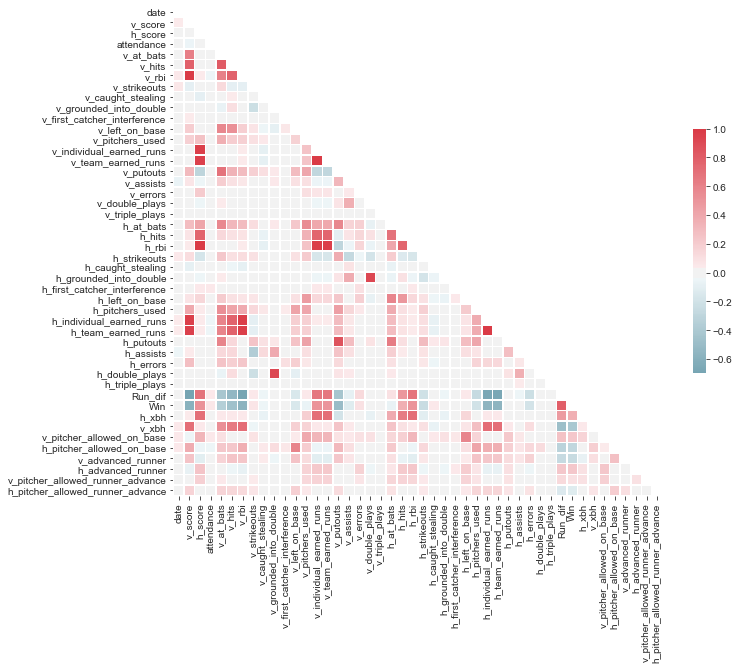

In [25]:
# Compute the correlation matrix
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
# Read in second dataset
df2 = pd.read_csv('file:///Users/chrisfiorentine/Downloads/datasets_3217_5288_baseball.csv')

## EDA

In [27]:
df2 = df2[df2['Year'] > 1998]

(array([ 1.,  8., 23., 81., 77., 82., 87., 53.,  7.,  1.]),
 array([ 43. ,  50.3,  57.6,  64.9,  72.2,  79.5,  86.8,  94.1, 101.4,
        108.7, 116. ]),
 <a list of 10 Patch objects>)

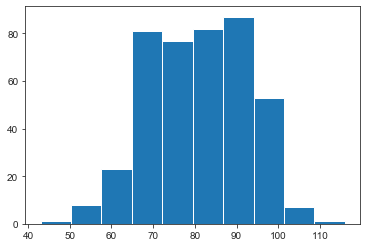

In [28]:
plt.hist(df2['W'])

In [29]:
playoffs_df = df2.loc[df2['Playoffs'] == 1]

In [30]:
playoffs_df['RA'].describe()

count    114.000000
mean     697.438596
std       63.508627
min      529.000000
25%      650.250000
50%      689.500000
75%      733.500000
max      860.000000
Name: RA, dtype: float64

In [31]:
playoffs_df['RS'].describe()

count     114.000000
mean      812.850877
std        74.074494
min       669.000000
25%       761.250000
50%       804.500000
75%       865.250000
max      1009.000000
Name: RS, dtype: float64

In [32]:
playoffs_df.describe()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0,114.000000,114.000000,114.000000,114.000000,114.000000
mean,2005.614035,812.850877,697.438596,94.482456,0.341184,0.434061,0.269044,1.0,3.649123,3.157895,161.973684,0.321412,0.403833
std,4.103762,74.074494,63.508627,4.892169,0.013191,0.020652,0.010876,0.0,1.838538,1.077353,0.363380,0.011056,0.019147
min,1999.000000,669.000000,529.000000,82.000000,0.310000,0.389000,0.238000,1.0,1.000000,1.000000,161.000000,0.296000,0.361000
25%,2002.000000,761.250000,650.250000,91.000000,0.332000,0.420250,0.262250,1.0,2.000000,3.000000,162.000000,0.314000,0.392000
50%,2006.000000,804.500000,689.500000,95.000000,0.341000,0.433500,0.269000,1.0,4.000000,4.000000,162.000000,0.321000,0.403500
75%,2009.000000,865.250000,733.500000,97.000000,0.350000,0.448000,0.277000,1.0,5.000000,4.000000,162.000000,0.328000,0.417000
max,2012.000000,1009.000000,860.000000,116.000000,0.373000,0.491000,0.293000,1.0,7.000000,5.000000,163.000000,0.348000,0.459000


In [33]:
df2['RD'] = df2['RS'] - df2['RA']

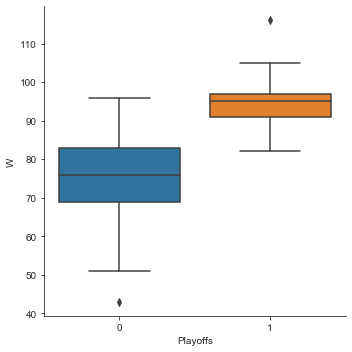

In [34]:
sns.catplot(data = df2, x = 'Playoffs', y = 'W', kind = 'box')

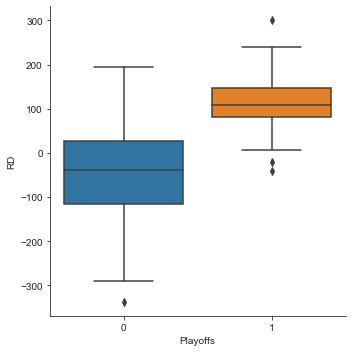

In [35]:
sns.catplot(data = df2, x = 'Playoffs', y = 'RD', kind = 'box')

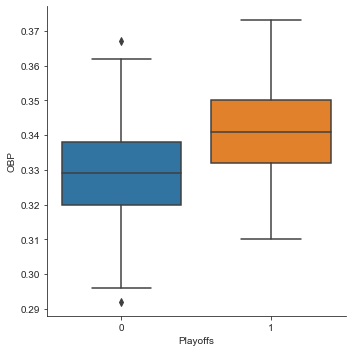

In [36]:
sns.catplot(data = df2, x = 'Playoffs', y = 'OBP', kind = 'box')

## Modeling

In [37]:
df2_features = df2.drop(columns = ['League', 'RankSeason','G','RankPlayoffs','Team','Playoffs','W','Year','RS','RA'])

In [38]:
target = df2['W']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df2_features, target,test_size=.25,random_state=30)

In [40]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns= df2_features.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns = df2_features.columns)

In [41]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 3.8324114578275443


In [42]:
y_test_pred = lm.predict(X_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Test Root Mean Squared Error:' , test_rmse)

Test Root Mean Squared Error: 3.9031019838651986


In [43]:
target2 = df2['Playoffs']

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2_features, target2,test_size=.25,random_state=25)

In [45]:
lr = LogisticRegression(solver='liblinear',class_weight='balanced')

lr.fit(X_train2, y_train2)

y_pred_test2 = lr.predict(X_test2)


print('Test Accuracy score: ', accuracy_score(y_test2, y_pred_test2))


print('Test F1 score: ', f1_score(y_test2, y_pred_test2))

Test Accuracy score:  0.819047619047619
Test F1 score:  0.7323943661971831


In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[60 15]
 [ 4 26]]


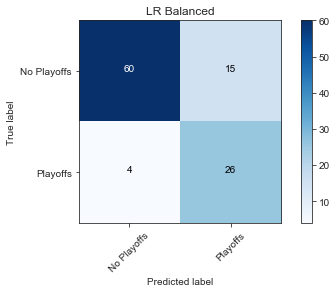

In [47]:
cm = confusion_matrix(y_test2,y_pred_test2)
classes = ['No Playoffs', 'Playoffs']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='LR Balanced',
                          cmap=plt.cm.Blues)

In [48]:
lr_coef01 = pd.DataFrame(data=lr.coef_).T
lr_coef01 = lr_coef01.set_index(X_train2.columns)
lr_coef01 = lr_coef01.sort_values(by = 0, ascending = False).T

In [49]:
lr_coef01.T.head(5)

,0
RD,0.037132
BA,-0.314431
OBP,-0.390766
OOBP,-0.400931
OSLG,-0.492859


## Feature Engineering

In [50]:
train = df.head(3993)
last_30_days = train.tail(381)

In [51]:
test = df.tail(861)

In [52]:
home_last30_mean = last_30_days.groupby('h_name').mean()

In [53]:
home_last30_mean = home_last30_mean.reset_index()

In [54]:
away_last30 = last_30_days.copy()

In [55]:
away_last30['Run_dif'] = -away_last30['Run_dif']

In [56]:
away_last30['Win'] = away_last30['Run_dif'].apply(wins)

In [57]:
away_last30_mean = away_last30.groupby('v_name').mean()

In [58]:
away_last30_mean = away_last30_mean.reset_index()

In [59]:
new_df = pd.read_csv('new_df') # DataFrame from workbook notebook

In [60]:
new_df

,date,v_score,h_score,Run_dif,Win,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed,v_name_ARI,v_name_ATL,v_name_BAL,v_name_BOS,v_name_CHA,v_name_CHN,v_name_CIN,v_name_CLE,v_name_COL,v_name_DET,v_name_HOU,v_name_KCA,v_name_LAN,v_name_MIA,v_name_MIL,v_name_MIN,v_name_NYA,v_name_NYN,v_name_OAK,v_name_PHI,v_name_PIT,v_name_SDN,v_name_SEA,v_name_SFN,v_name_SLN,v_name_TBA,v_name_TEX,v_name_TOR,v_name_WAS,h_name_ARI,h_name_ATL,h_name_BAL,h_name_BOS,h_name_CHA,h_name_CHN,h_name_CIN,h_name_CLE,h_name_COL,h_name_DET,h_name_HOU,h_name_KCA,h_name_LAN,h_name_MIA,h_name_MIL,h_name_MIN,h_name_NYA,h_name_NYN,h_name_OAK,h_name_PHI,h_name_PIT,h_name_SDN,h_name_SEA,h_name_SFN,h_name_SLN,h_name_TBA,h_name_TEX,h_name_TOR,h_name_WAS
0,20150405,3,0,-3,0.0,1.933333,0.400000,0.600000,0.600000,7.933333,8.300000,6.933333,7.900000,2.866667,3.800000,2.266667,3.500000,4.800000,4.600000,1.266667,0.600000,0.666667,0.100000,7.400000,7.500000,6.266667,5.900000,3.133333,3.200000,41268.800000,28362.800000,8.266667,9.400000,8.533333,7.400000,0.266667,0.500000,0.600000,1.100000,0.666667,0.700000,4.933333,4.500000,3.000000,4.100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20150406,0,4,4,1.0,1.555556,1.545455,0.666667,0.636364,8.555556,10.454545,6.444444,9.090909,2.444444,3.909091,1.777778,2.818182,2.333333,3.545455,0.888889,1.090909,0.444444,0.363636,5.333333,6.727273,5.888889,6.272727,3.222222,3.272727,34247.888889,36296.636364,5.888889,8.727273,9.000000,6.636364,0.333333,0.727273,0.444444,1.272727,0.888889,0.727273,4.888889,6.363636,3.333333,4.818182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20150406,0,2,2,1.0,1.250000,-1.083333,0.625000,0.416667,7.750000,9.250000,8.000000,9.416667,3.062500,3.000000,2.750000,3.250000,3.187500,3.333333,0.937500,0.750000,0.687500,0.416667,5.812500,7.166667,6.437500,7.916667,3.125000,4.750000,30538.062500,35996.916667,8.062500,8.833333,9.250000,9.083333,0.187500,0.500000,0.937500,0.583333,0.687500,1.416667,4.562500,4.250000,3.312500,5.333333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20150406,1,10,9,1.0,-1.923077,-1.714286,0.384615,0.285714,8.076923,8.285714,10.230769,6.714286,2.615385,3.071429,3.307692,3.214286,2.692308,2.500000,0.692308,0.357143,0.384615,0.142857,5.846154,6.785714,7.692308,5.428571,4.153846,4.428571,32015.307692,33233.500000,7.230769,8.500000,7.307692,7.071429,0.461538,0.785714,1.076923,1.142857,1.076923,1.000000,3.615385,2.785714,5.538462,4.500000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20150406,6,1,-5,0.0,0.900000,2.000000,0.600000,0.600000,7.000000,9.000000,7.200000,8.600000,2.100000,3.200000,1.900000,2.400000,3.300000,4.600000,0.800000,0.600000,0.20

## Modeling

In [61]:
# Function to fit a model and predict outcomes

def fit_predict_classes(model, x_train, y_train, x_test,y_test):
    model.fit(x_train, y_train)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    
    print('Training Accuracy score: ', accuracy_score(y_train, train_predictions))

    print('Training F1 score: ', f1_score(y_train, train_predictions))
    
    print('Training ROC AUC score: ', roc_auc_score(y_train, train_predictions))
    
    print()

    print('Testing Accuracy score: ', accuracy_score(y_test, test_predictions))

    print('Testing F1 score: ', f1_score(y_test, test_predictions))
    
    print('Testing ROC AUC score: ', roc_auc_score(y_test, test_predictions))

In [62]:
# Instantiating Logistic Regression Classification
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced') 

In [63]:
# Instantiate Random Forest Classifier
rfc = RandomForestClassifier()

In [64]:
# Instantiate XGBoost 
xgb = xgb_est = xgb.XGBClassifier(objective = 'binary:logistic')

In [65]:
df_2016 = pd.read_csv('df3') # DataFrame from functions notebook

In [66]:
df_2016 = df_2016.drop(columns = ['attendance','v_at_bats','v_hits','v_rbi','v_strikeouts',
                            'v_caught_stealing',
       'v_grounded_into_double', 'v_first_catcher_interference',
       'v_left_on_base', 'v_pitchers_used', 'v_individual_earned_runs',
       'v_team_earned_runs', 'v_putouts', 'v_assists', 'v_errors',
       'v_double_plays', 'v_triple_plays', 'h_at_bats', 'h_hits', 'h_rbi',
       'h_strikeouts', 'h_caught_stealing', 'h_grounded_into_double',
       'h_first_catcher_interference', 'h_left_on_base', 'h_pitchers_used',
       'h_individual_earned_runs', 'h_team_earned_runs', 'h_putouts',
       'h_assists', 'h_errors', 'h_double_plays', 'h_triple_plays','h_xbh', 'v_xbh',
       'v_pitcher_allowed_on_base', 'h_pitcher_allowed_on_base',
       'v_advanced_runner', 'h_advanced_runner',
       'v_pitcher_allowed_runner_advance', 'h_pitcher_allowed_runner_advance'])

In [67]:
full_df = pd.read_csv('full_df')

In [68]:
full_df

,date,v_name,h_name,v_score,h_score,Run_dif,Win,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed
0,20150405,SLN,CHN,3,0,-3,0.0,2.033333,-1.833333,0.733333,0.400000,7.566667,9.733333,6.366667,8.400000,2.733333,3.533333,1.933333,3.000000,5.433333,4.533333,0.900000,1.066667,0.600000,0.266667,7.066667,7.200000,6.166667,6.600000,3.966667,3.566667,38349.633333,29912.666667,8.333333,8.200000,9.566667,7.400000,0.633333,0.966667,1.033333,1.233333,0.566667,0.833333,4.833333,6.200000,2.800000,4.366667,1.933333,0.400000,0.600000,0.600000,7.933333,8.300000,6.933333,7.900000,2.866667,3.800000,2.266667,3.500000,4.800000,4.600000,1.266667,0.600000,0.666667,0.100000,7.400000,7.500000,6.266667,5.900000,3.133333,3.200000,41268.800000,28362.800000,8.266667,9.400000,8.533333,7.400000,0.266667,0.500000,0.600000,1.100000,0.666667,0.700000,4.933333,4.500000,3.000000,4.100000
1,20150406,MIN,DET,0,4,4,1.0,0.600000,1.620690,0.566667,0.758621,9.500000,8.137931,8.666667,9.551724,3.066667,2.758621,3.166667,3.689655,3.366667,3.724138,0.766667,1.068966,0.500000,0.655172,6.733333,7.172414,6.200000,6.827586,3.266667,3.758621,29757.500000,24891.241379,8.066667,10.379310,7.566667,7.896552,0.466667,0.482759,0.866667,0.793103,0.966667,0.689655,5.166667,3.793103,4.566667,5.413793,1.555556,1.545455,0.666667,0.636364,8.555556,10.454545,6.444444,9.090909,2.444444,3.909091,1.777778,2.818182,2.333333,3.545455,0.888889,1.090909,0.444444,0.363636,5.333333,6.727273,5.888889,6.272727,3.222222,3.272727,34247.888889,36296.636364,5.888889,8.727273,9.000000,6.636364,0.333333,0.727273,0.444444,1.272727,0.888889,0.727273,4.888889,6.363636,3.333333,4.818182
2,20150406,CLE,HOU,0,2,2,1.0,0.709677,-0.451613,0.548387,0.451613,7.967742,7.806452,9.064516,7.354839,3.354839,2.967742,2.935484,2.870968,4.419355,3.161290,1.096774,1.419355,0.612903,0.451613,7.225806,6.161290,7.064516,6.225806,2.774194

In [69]:
df_2016

,date,v_name,h_name,v_score,h_score,Run_dif,Win,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed
0,20150405,SLN,CHN,3,0,-3,0.0,2.033333,-1.833333,0.733333,0.400000,7.566667,9.733333,6.366667,8.400000,2.733333,3.533333,1.933333,3.000000,5.433333,4.533333,0.900000,1.066667,0.600000,0.266667,7.066667,7.200000,6.166667,6.600000,3.966667,3.566667,38349.633333,29912.666667,8.333333,8.200000,9.566667,7.400000,0.633333,0.966667,1.033333,1.233333,0.566667,0.833333,4.833333,6.200000,2.800000,4.366667
1,20150406,MIN,DET,0,4,4,1.0,0.600000,1.620690,0.566667,0.758621,9.500000,8.137931,8.666667,9.551724,3.066667,2.758621,3.166667,3.689655,3.366667,3.724138,0.766667,1.068966,0.500000,0.655172,6.733333,7.172414,6.200000,6.827586,3.266667,3.758621,29757.500000,24891.241379,8.066667,10.379310,7.566667,7.896552,0.466667,0.482759,0.866667,0.793103,0.966667,0.689655,5.166667,3.793103,4.566667,5.413793
2,20150406,CLE,HOU,0,2,2,1.0,0.709677,-0.451613,0.548387,0.451613,7.967742,7.806452,9.064516,7.354839,3.354839,2.967742,2.935484,2.870968,4.419355,3.161290,1.096774,1.419355,0.612903,0.451613,7.225806,6.161290,7.064516,6.225806,2.774194,3.677419,27285.419355,22244.548387,10.258065,9.000000,9.483871,8.741935,0.451613,0.516129,0.838710,0.548387,0.774194,0.741935,4.290323,4.064516,3.580645,3.612903
3,20150406,CHA,KCA,1,10,9,1.0,0.846154,-0.281250,0.730769,0.500000,9.153846,8.812500,8.884615,8.781250,2.884615,2.718750,2.461538,2.625000,2.923077,3.250000,1.384615,0.812500,0.346154,0.562500,6.423077,6.968750,7.769231,7.531250,3.346154,3.937500,32315.846154,27600.062500,6.461538,8.250000,9.538462,7.625000,0.461538,0.468750,0.269231,0.781250,0.884615,0.781250,4.576923,4.437500,3.730769,4.156250
4,20150406,TOR,NYA,6,1,-5,0.0,0.633333,-0.515152,0.600000,0.454545,8.366667,7.393939,8.700000,7.363636,3.200000,2.848485,3.433333,2.636364,3.533333,4.242424,1.066667,0.484848,0.100000,0.606061,6.566667,6.545455,6.533333,6.484848,2.633333,3.606061,37788.266667,30675.575758,6.500000,8.242424,9.100000,7.454545,0.433333,0.393939,0.633333,0.878788,0.600000,1.060606,4.766667,3.969697,4.133333,3.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,20161002,MIL,COL,6,4,-2,0.0,-1.222222,1.037037,0.407407,0.592593,10.333333,7.666667,11.444444,8.851852,4.518519,2.444444,4.777778,3.592593,3.962963,4.518519,1.111111,1.555556,0.370370,0.333333,7.518519,7.185185,6.740741,7.222222,3.666667,4.185185,30312.407407,26780.407407,7.111111,10.111111,7.740741,7.185185,0.851852,0.777778,1.000000,0.666667,0.814815,0.851852,5.888889,3.777778,7.111111,4.814815
4850,20161002,NYN,PHI,2,5,3,1.0,-1.093750,-0.878788,0.500000,0.424242,7.031250,8.575758,8.437500,8.515152,2.187500,3.606061,3.343750,2.515152,3.031250,3.939394,1.000000,0.606061,0.406250,0.363636,5.843750,7.181818,6.906250,6.787879,3.468750,2.242424,24352.718750,29172.393939,8.000000,9.242424,9.562500,7.96969

In [70]:
new_df

,date,v_score,h_score,Run_dif,Win,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed,v_name_ARI,v_name_ATL,v_name_BAL,v_name_BOS,v_name_CHA,v_name_CHN,v_name_CIN,v_name_CLE,v_name_COL,v_name_DET,v_name_HOU,v_name_KCA,v_name_LAN,v_name_MIA,v_name_MIL,v_name_MIN,v_name_NYA,v_name_NYN,v_name_OAK,v_name_PHI,v_name_PIT,v_name_SDN,v_name_SEA,v_name_SFN,v_name_SLN,v_name_TBA,v_name_TEX,v_name_TOR,v_name_WAS,h_name_ARI,h_name_ATL,h_name_BAL,h_name_BOS,h_name_CHA,h_name_CHN,h_name_CIN,h_name_CLE,h_name_COL,h_name_DET,h_name_HOU,h_name_KCA,h_name_LAN,h_name_MIA,h_name_MIL,h_name_MIN,h_name_NYA,h_name_NYN,h_name_OAK,h_name_PHI,h_name_PIT,h_name_SDN,h_name_SEA,h_name_SFN,h_name_SLN,h_name_TBA,h_name_TEX,h_name_TOR,h_name_WAS
0,20150405,3,0,-3,0.0,1.933333,0.400000,0.600000,0.600000,7.933333,8.300000,6.933333,7.900000,2.866667,3.800000,2.266667,3.500000,4.800000,4.600000,1.266667,0.600000,0.666667,0.100000,7.400000,7.500000,6.266667,5.900000,3.133333,3.200000,41268.800000,28362.800000,8.266667,9.400000,8.533333,7.400000,0.266667,0.500000,0.600000,1.100000,0.666667,0.700000,4.933333,4.500000,3.000000,4.100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20150406,0,4,4,1.0,1.555556,1.545455,0.666667,0.636364,8.555556,10.454545,6.444444,9.090909,2.444444,3.909091,1.777778,2.818182,2.333333,3.545455,0.888889,1.090909,0.444444,0.363636,5.333333,6.727273,5.888889,6.272727,3.222222,3.272727,34247.888889,36296.636364,5.888889,8.727273,9.000000,6.636364,0.333333,0.727273,0.444444,1.272727,0.888889,0.727273,4.888889,6.363636,3.333333,4.818182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20150406,0,2,2,1.0,1.250000,-1.083333,0.625000,0.416667,7.750000,9.250000,8.000000,9.416667,3.062500,3.000000,2.750000,3.250000,3.187500,3.333333,0.937500,0.750000,0.687500,0.416667,5.812500,7.166667,6.437500,7.916667,3.125000,4.750000,30538.062500,35996.916667,8.062500,8.833333,9.250000,9.083333,0.187500,0.500000,0.937500,0.583333,0.687500,1.416667,4.562500,4.250000,3.312500,5.333333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20150406,1,10,9,1.0,-1.923077,-1.714286,0.384615,0.285714,8.076923,8.285714,10.230769,6.714286,2.615385,3.071429,3.307692,3.214286,2.692308,2.500000,0.692308,0.357143,0.384615,0.142857,5.846154,6.785714,7.692308,5.428571,4.153846,4.428571,32015.307692,33233.500000,7.230769,8.500000,7.307692,7.071429,0.461538,0.785714,1.076923,1.142857,1.076923,1.000000,3.615385,2.785714,5.538462,4.500000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20150406,6,1,-5,0.0,0.900000,2.000000,0.600000,0.600000,7.000000,9.000000,7.200000,8.600000,2.100000,3.200000,1.900000,2.400000,3.300000,4.600000,0.800000,0.600000,0.20

In [71]:
full_df = full_df.drop_duplicates()

In [72]:
full_df.describe()

,date,v_score,h_score,Run_dif,Win,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed
count,4.853000e+03,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000,4853.000000
mean,2.015568e+07,4.290954,4.440346,0.149392,0.535751,-0.013497,0.002631,0.519278,0.520996,8.371279,8.765452,8.750780,8.385395,2.923301,3.039891,3.020451,2.933689,3.754225,3.548209,0.957102,0.985358,0.460340,0.499087,6.733955,6.759858,6.753580,6.733295,3.536680,3.770259,29075.709509,29056.369439,7.654484,8.368833,8.378630,7.654000,0.563509,0.583532,0.892280,0.863875,0.860911,0.895245,4.349164,4.375938,4.362661,4.378569,0.453660,-0.412492,0.580595,0.432145,8.572809,8.581930,8.552729,8.580037,3.102401,2.928907,2.902312,3.096147,3.659702,3.470648,1.053441,0.913537,0.501195,0.435719,6.574091,6.924450,6.889028,6.591687,3.428038,3.639700,32761.959521,33165.828909,7.574149,8.363448,8.300500,7.585910,0.648475,0.557478,0.914864,0.926410,0.942769,0.901975,4

In [73]:
full_df_dummies = pd.get_dummies(full_df, columns = ['v_name','h_name'], drop_first = True)

In [74]:
train_df2 = full_df_dummies[full_df_dummies['date'] > 20160000]
train_df2 = train_df2.head(1565)

In [75]:
train_df2

,date,v_score,h_score,Run_dif,Win,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed,v_name_ARI,v_name_ATL,v_name_BAL,v_name_BOS,v_name_CHA,v_name_CHN,v_name_CIN,v_name_CLE,v_name_COL,v_name_DET,v_name_HOU,v_name_KCA,v_name_LAN,v_name_MIA,v_name_MIL,v_name_MIN,v_name_NYA,v_name_NYN,v_name_OAK,v_name_PHI,v_name_PIT,v_name_SDN,v_name_SEA,v_name_SFN,v_name_SLN,v_name_TBA,v_name_TEX,v_name_TOR,v_name_WAS,h_name_ARI,h_name_ATL,h_name_BAL,h_name_BOS,h_name_CHA,h_name_CHN,h_name_CIN,h_name_CLE,h_name_COL,h_name_DET,h_name_HOU,h_name_KCA,h_name_LAN,h_name_MIA,h_name_MIL,h_name_MIN,h_name_NYA,h_name_NYN,h_name_OAK,h_name_PHI,h_name_PIT,h_name_SDN,h_name_SEA,h_name_SFN,h_name_SLN,h_name_TBA,h_name_TEX,h_name_TOR,h_name_WAS
2427,20160403,3,4,1,1.0,0.846154,-0.878788,0.730769,0.424242,9.153846,8.575758,8.884615,8.515152,2.884615,3.606061,2.461538,2.515152,2.923077,3.939394,1.384615,0.606061,0.346154,0.363636,6.423077,7.181818,7.769231,6.787879,3.346154,2.242424,32315.846154,29172.393939,6.461538,9.242424,9.538462,7.969697,0.461538,0.484848,0.269231,0.757576,0.884615,0.939394,4.576923,3.969697,3.730769,3.090909,-1.923077,-0.222222,0.384615,0.555556,8.076923,7.888889,10.230769,8.111111,2.615385,2.444444,3.307692,2.555556,2.692308,2.888889,0.692308,1.666667,0.384615,0.333333,5.846154,7.222222,7.692308,7.000000,4.153846,2.666667,32015.307692,32868.777778,7.230769,7.222222,7.307692,7.444444,0.461538,0.777778,1.076923,0.444444,1.076923,0.555556,3.615385,3.000000,5.538462,3.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2428,20160403,5,3,-2,0.0,-0.555556,-0.515152,0.444444,0.454545,7.000000,7.393939,7.555556,7.363636,2.925926,2.848485,2.518519,2.636364,3.222222,4.242424,0.555556,0.484848,0.407407,0.606061,6.333333,6.545455,5.777778,6.484848,2.888889,3.606061,16568.037037,30675.5757

In [76]:
test_df2 = full_df_dummies.loc[3992:4415]

In [77]:
test_df2

,date,v_score,h_score,Run_dif,Win,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed,v_name_ARI,v_name_ATL,v_name_BAL,v_name_BOS,v_name_CHA,v_name_CHN,v_name_CIN,v_name_CLE,v_name_COL,v_name_DET,v_name_HOU,v_name_KCA,v_name_LAN,v_name_MIA,v_name_MIL,v_name_MIN,v_name_NYA,v_name_NYN,v_name_OAK,v_name_PHI,v_name_PIT,v_name_SDN,v_name_SEA,v_name_SFN,v_name_SLN,v_name_TBA,v_name_TEX,v_name_TOR,v_name_WAS,h_name_ARI,h_name_ATL,h_name_BAL,h_name_BOS,h_name_CHA,h_name_CHN,h_name_CIN,h_name_CLE,h_name_COL,h_name_DET,h_name_HOU,h_name_KCA,h_name_LAN,h_name_MIA,h_name_MIL,h_name_MIN,h_name_NYA,h_name_NYN,h_name_OAK,h_name_PHI,h_name_PIT,h_name_SDN,h_name_SEA,h_name_SFN,h_name_SLN,h_name_TBA,h_name_TEX,h_name_TOR,h_name_WAS
3992,20160801,12,5,-7,0.0,1.000000,1.620690,0.586207,0.758621,9.586207,8.137931,8.862069,9.551724,3.206897,2.758621,3.241379,3.689655,3.965517,3.724138,1.000000,1.068966,0.344828,0.655172,6.965517,7.172414,6.344828,6.827586,2.931034,3.758621,15450.689655,24891.241379,7.172414,10.379310,7.965517,7.896552,0.517241,0.482759,0.827586,0.793103,1.241379,0.689655,5.413793,3.793103,4.413793,5.413793,1.333333,1.545455,0.583333,0.636364,9.416667,10.454545,8.916667,9.090909,3.833333,3.909091,3.416667,2.818182,4.166667,3.545455,1.583333,1.090909,0.333333,0.363636,6.750000,6.727273,6.750000,6.272727,3.250000,3.272727,28140.250000,36296.636364,7.333333,8.727273,8.583333,6.636364,0.750000,0.727273,1.000000,1.272727,0.750000,0.727273,6.083333,6.363636,4.750000,4.818182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3993,20160801,1,2,1,1.0,0.709677,-0.515152,0.548387,0.454545,7.967742,7.393939,9.064516,7.363636,3.354839,2.848485,2.935484,2.636364,4.419355,4.242424,1.096774,0.484848,0.612903,0.606061,7.225806,6.545455,7.064516,6.484848,2.774194,3.606061,27285.419355,30675.575758

In [78]:
X_train_final = train_df2.drop(columns = ['date', 'Run_dif', 'Win','v_score','h_score'
                                       ])

In [79]:
X_train_final

,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed,v_name_ARI,v_name_ATL,v_name_BAL,v_name_BOS,v_name_CHA,v_name_CHN,v_name_CIN,v_name_CLE,v_name_COL,v_name_DET,v_name_HOU,v_name_KCA,v_name_LAN,v_name_MIA,v_name_MIL,v_name_MIN,v_name_NYA,v_name_NYN,v_name_OAK,v_name_PHI,v_name_PIT,v_name_SDN,v_name_SEA,v_name_SFN,v_name_SLN,v_name_TBA,v_name_TEX,v_name_TOR,v_name_WAS,h_name_ARI,h_name_ATL,h_name_BAL,h_name_BOS,h_name_CHA,h_name_CHN,h_name_CIN,h_name_CLE,h_name_COL,h_name_DET,h_name_HOU,h_name_KCA,h_name_LAN,h_name_MIA,h_name_MIL,h_name_MIN,h_name_NYA,h_name_NYN,h_name_OAK,h_name_PHI,h_name_PIT,h_name_SDN,h_name_SEA,h_name_SFN,h_name_SLN,h_name_TBA,h_name_TEX,h_name_TOR,h_name_WAS
2427,0.846154,-0.878788,0.730769,0.424242,9.153846,8.575758,8.884615,8.515152,2.884615,3.606061,2.461538,2.515152,2.923077,3.939394,1.384615,0.606061,0.346154,0.363636,6.423077,7.181818,7.769231,6.787879,3.346154,2.242424,32315.846154,29172.393939,6.461538,9.242424,9.538462,7.969697,0.461538,0.484848,0.269231,0.757576,0.884615,0.939394,4.576923,3.969697,3.730769,3.090909,-1.923077,-0.222222,0.384615,0.555556,8.076923,7.888889,10.230769,8.111111,2.615385,2.444444,3.307692,2.555556,2.692308,2.888889,0.692308,1.666667,0.384615,0.333333,5.846154,7.222222,7.692308,7.000000,4.153846,2.666667,32015.307692,32868.777778,7.230769,7.222222,7.307692,7.444444,0.461538,0.777778,1.076923,0.444444,1.076923,0.555556,3.615385,3.000000,5.538462,3.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2428,-0.555556,-0.515152,0.444444,0.454545,7.000000,7.393939,7.555556,7.363636,2.925926,2.848485,2.518519,2.636364,3.222222,4.242424,0.555556,0.484848,0.407407,0.606061,6.333333,6.545455,5.777778,6.484848,2.888889,3.606061,16568.037037,30675.575758,9.259259,8.242424,8.888889,7.454545,0.555556,0.393939,0.629630,0.8787

In [80]:
y_train_final = train_df2.Win

In [81]:
y_train_final

2427    1.0
2428    0.0
2429    1.0
2430    0.0
2431    1.0
       ... 
3987    1.0
3988    1.0
3989    1.0
3990    0.0
3991    1.0
Name: Win, Length: 1565, dtype: float64

In [82]:
X_test_final = test_df2.drop(columns = ['date', 'Run_dif', 'Win','v_score','h_score'
                                       ])

In [83]:
X_test_final

,h_2016_avg_rd,v_2016_avg_rd,h_2016_win_rate,v_2016_win_rate,h_2016_avg_hits,v_2016_avg_hits,h_2016_avg_hits_allowed,v_2016_avg_hits_allowed,h_2016_avg_xbh,v_2016_avg_xbh,h_2016_avg_xbh_allowed,v_2016_avg_xbh_allowed,h_2016_avg_on_base_by_pitcher,v_2016_avg_on_base_by_pitcher,h_2016_avg_runners_advanced,v_2016_avg_runners_advanced,h_2016_avg_pitcher_allowed_runners_advance,v_2016_avg_pitcher_allowed_runners_advance,h_2016_avg_runners_left_on_base,v_2016_avg_runners_left_on_base,h_2016_avg_runners_stopped_from_scoring,v_2016_avg_runners_stopped_from_scoring,h_2016_avg_allowed_on_base,v_2016_avg_allowed_on_base,h_2016_avg_attendance,v_2016_avg_attendance,h_2016_avg_getting_struk_out,v_2016_avg_getting_struck_out,h_2016_avg_striking_out_opponents,v_2016_avg_striking_out_opponents,h_2016_avg_errors_made,v_2016_avg_errors_made,h_2016_avg_double_plays_made,v_2016_avg_double_plays_made,h_2016_avg_double_plays_hit_into,v_2016_avg_double_plays_hit_into,h_2016_avg_runs_scored,v_2016_avg_runs_scored,h_2016_avg_runs_allowed,v_2016_avg_runs_allowed,h_30_day_avg_rd,v_30_day_avg_rd,h_30_day_win_rate,v_30_day_win_rate,h_30_day_avg_hits,v_30_day_avg_hits,h_30_day_avg_hits_allowed,v_30_day_avg_hits_allowed,h_30_day_avg_xbh,v_30_day_avg_xbh,h_30_day_avg_xbh_allowed,v_30_day_avg_xbh_allowed,h_30_day_avg_on_base_by_pitcher,v_30_day_avg_on_base_by_pitcher,h_30_day_avg_runners_advanced,v_30_day_avg_runners_advanced,h_30_day_avg_pitcher_allowed_runners_advance,v_30_day_avg_pitcher_allowed_runners_advance,h_30_day_avg_runners_left_on_base,v_30_day_avg_runners_left_on_base,h_30_day_avg_runners_stopped_from_scoring,v_30_day_avg_runners_stopped_from_scoring,h_30_day_avg_allowed_on_base,v_30_day_avg_allowed_on_base,h_30_day_avg_attendance,v_30_day_avg_attendance,h_30_day_avg_getting_struk_out,v_30_day_avg_getting_struck_out,h_30_day_avg_striking_out_opponents,v_30_day_avg_striking_out_opponents,h_30_day_avg_errors_made,v_30_day_avg_errors_made,h_30_day_avg_double_plays_made,v_30_day_avg_double_plays_made,h_30_day_avg_double_plays_hit_into,v_30_day_avg_double_plays_hit_into,h_30_day_avg_runs_scored,v_30_day_avg_runs_scored,h_30_day_avg_runs_allowed,v_30_day_avg_runs_allowed,v_name_ARI,v_name_ATL,v_name_BAL,v_name_BOS,v_name_CHA,v_name_CHN,v_name_CIN,v_name_CLE,v_name_COL,v_name_DET,v_name_HOU,v_name_KCA,v_name_LAN,v_name_MIA,v_name_MIL,v_name_MIN,v_name_NYA,v_name_NYN,v_name_OAK,v_name_PHI,v_name_PIT,v_name_SDN,v_name_SEA,v_name_SFN,v_name_SLN,v_name_TBA,v_name_TEX,v_name_TOR,v_name_WAS,h_name_ARI,h_name_ATL,h_name_BAL,h_name_BOS,h_name_CHA,h_name_CHN,h_name_CIN,h_name_CLE,h_name_COL,h_name_DET,h_name_HOU,h_name_KCA,h_name_LAN,h_name_MIA,h_name_MIL,h_name_MIN,h_name_NYA,h_name_NYN,h_name_OAK,h_name_PHI,h_name_PIT,h_name_SDN,h_name_SEA,h_name_SFN,h_name_SLN,h_name_TBA,h_name_TEX,h_name_TOR,h_name_WAS
3992,1.000000,1.620690,0.586207,0.758621,9.586207,8.137931,8.862069,9.551724,3.206897,2.758621,3.241379,3.689655,3.965517,3.724138,1.000000,1.068966,0.344828,0.655172,6.965517,7.172414,6.344828,6.827586,2.931034,3.758621,15450.689655,24891.241379,7.172414,10.379310,7.965517,7.896552,0.517241,0.482759,0.827586,0.793103,1.241379,0.689655,5.413793,3.793103,4.413793,5.413793,1.333333,1.545455,0.583333,0.636364,9.416667,10.454545,8.916667,9.090909,3.833333,3.909091,3.416667,2.818182,4.166667,3.545455,1.583333,1.090909,0.333333,0.363636,6.750000,6.727273,6.750000,6.272727,3.250000,3.272727,28140.250000,36296.636364,7.333333,8.727273,8.583333,6.636364,0.750000,0.727273,1.000000,1.272727,0.750000,0.727273,6.083333,6.363636,4.750000,4.818182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3993,0.709677,-0.515152,0.548387,0.454545,7.967742,7.393939,9.064516,7.363636,3.354839,2.848485,2.935484,2.636364,4.419355,4.242424,1.096774,0.484848,0.612903,0.606061,7.225806,6.545455,7.064516,6.484848,2.774194,3.606061,27285.419355,30675.575758,10.258065,8.242424,9.483871,7.454545,0.451613,0.393939,0.838710,0.878788

In [84]:
y_test_final = test_df2.Win

In [85]:
y_test_final

3992    0.0
3993    1.0
3994    0.0
3995    0.0
3996    0.0
       ... 
4411    0.0
4412    1.0
4413    1.0
4414    0.0
4415    1.0
Name: Win, Length: 424, dtype: float64

In [86]:
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_final =pd.DataFrame(data=scaler.transform(X_train_final), columns= X_train_final.columns)
X_test_final =pd.DataFrame(data=scaler.transform(X_test_final), columns = X_test_final.columns)

In [87]:
# Fit Predict Log Reg
fit_predict_classes(log_reg, X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.5980830670926518
Training F1 score:  0.6171637248934876
Training ROC AUC score:  0.5973904870631539

Testing Accuracy score:  0.5613207547169812
Testing F1 score:  0.6059322033898304
Testing ROC AUC score:  0.5557149260421336


In [88]:
param_grid2 = dict(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000], penalty=['l1','l2'])
print(param_grid2)

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}


In [89]:
lr_gs = GridSearchCV(LogisticRegression(), param_grid2, verbose=1, cv=7)

In [90]:
lr_gs.fit(X_train, y_train)

Fitting 7 folds for each of 14 candidates, totalling 98 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    1.9s finished


GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [91]:
print(lr_gs.best_score_)
print(lr_gs.best_params_)
print(lr_gs.best_estimator_)

0.12063492063492062
{'C': 0.1, 'penalty': 'l2'}
LogisticRegression(C=0.1)


In [92]:
fit_predict_classes(lr_gs.best_estimator_,X_train_final, y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.6038338658146964
Training F1 score:  0.6582138919514884
Training ROC AUC score:  0.5959437648239821

Testing Accuracy score:  0.5518867924528302
Testing F1 score:  0.6274509803921569
Testing ROC AUC score:  0.5385477364410578


In [93]:
# Fit Predict Random Forest
fit_predict_classes(rfc, X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.7201277955271566
Training F1 score:  0.7476958525345622
Training ROC AUC score:  0.7160381134217113

Testing Accuracy score:  0.5141509433962265
Testing F1 score:  0.5635593220338984
Testing ROC AUC score:  0.5082025997310623


In [94]:
rf_param_grid = { 
    'n_estimators': [100,150,200],
    'max_depth': [1,5,10,15],
    'max_features': [1.0,2,4,6,8],
    'min_samples_split': [2,20,40,50]}

In [95]:
rf_grid_search = GridSearchCV(rfc, rf_param_grid, cv = 5, scoring = 'accuracy', verbose = 1)
rf_grid_search.fit(X_train_final,y_train_final)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  7.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10, 15],
                         'max_features': [1.0, 2, 4, 6, 8],
                         'min_samples_split': [2, 20, 40, 50],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=1)

In [96]:
print(rf_grid_search.best_score_)
print(rf_grid_search.best_params_)
print(rf_grid_search.best_estimator_)

0.5597444089456869
{'max_depth': 1, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 150}
RandomForestClassifier(max_depth=1, max_features=8, n_estimators=150)


In [97]:
fit_predict_classes(rf_grid_search.best_estimator_,X_train_final, y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.5686900958466453
Training F1 score:  0.6952595936794582
Training ROC AUC score:  0.5437100388088982

Testing Accuracy score:  0.5400943396226415
Testing F1 score:  0.6733668341708543
Testing ROC AUC score:  0.5091214701927387


In [98]:
# Fit Predict XGBoost
fit_predict_classes(xgb, X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.7201277955271566
Training F1 score:  0.7408284023668639
Training ROC AUC score:  0.7179810187417781

Testing Accuracy score:  0.5754716981132075
Testing F1 score:  0.620253164556962
Testing ROC AUC score:  0.5695652173913044


In [99]:
param_dist = {'n_estimators': [100,300,500],
              'learning_rate': [0.1,0.07,0.05,0.03,0.01],
              'max_depth': [3, 4, 5, 7, 8],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }

In [100]:
xgb_gs = GridSearchCV(
    estimator = xgb_est,
    param_grid = param_dist, 
    scoring='accuracy',
    #n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [101]:
xgb_gs.fit(X_train_final,y_train_final)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed: 49.1min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method=None,
                                     

In [102]:
print(xgb_gs.best_score_)
print(xgb_gs.best_params_)
print(xgb_gs.best_estimator_)

0.549520766773163
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [103]:
fit_predict_classes(xgb_gs.best_estimator_,X_train_final, y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.6185303514376996
Training F1 score:  0.6732348111658456
Training ROC AUC score:  0.6101551043706759

Testing Accuracy score:  0.5518867924528302
Testing F1 score:  0.6274509803921569
Testing ROC AUC score:  0.5385477364410578


In [104]:
xgb_pred = xgb.predict(X_test_final)

Confusion Matrix, without normalization
[[ 97  97]
 [ 83 147]]


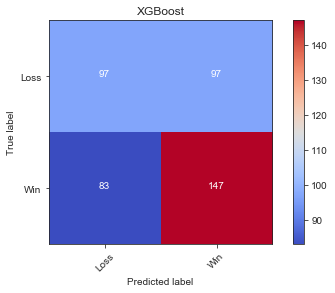

In [105]:
cm = confusion_matrix(y_test_final,xgb_pred)
classes = ['Loss', 'Win']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='XGBoost',
                          cmap=plt.cm.coolwarm)

In [106]:
#Fit Predict Dummy Classifier
fit_predict_classes(DummyClassifier(),X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.49456869009584664
Training F1 score:  0.5237808549066828
Training ROC AUC score:  0.49266551191331476

Testing Accuracy score:  0.45754716981132076
Testing F1 score:  0.5021645021645021
Testing ROC AUC score:  0.4532048408785298


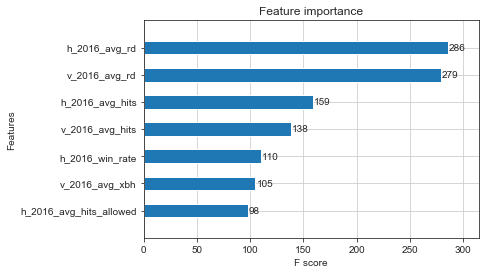

In [107]:
plot_importance(xgb, max_num_features=7,height = 0.5)

In [108]:
xgb_features = xgb.get_booster().get_fscore()

In [109]:
pd.DataFrame.from_dict(xgb_features, orient = 'index').sort_values(by = 0, ascending = False).head(10)

,0
h_2016_avg_rd,286
v_2016_avg_rd,279
h_2016_avg_hits,159
v_2016_avg_hits,138
h_2016_win_rate,110
v_2016_avg_xbh,105
h_2016_avg_hits_allowed,98
v_2016_avg_hits_allowed,82
h_2016_avg_on_base_by_pitcher,78
h_2016_avg_xbh,77


## Conclusion 

XGBoost and Random Forest had the best models at 55% accuracy. 
Most important features are Run Dif, Hits, Walks, and scoring when there are runners on base. 